In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

/home/rupamay/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#Load data into a pandas dataframe
df = pd.read_csv('Total_Average_features.csv',delimiter=',',low_memory=False)

In [3]:
df.head(5)

,Unnamed: 0,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate,Weight_diff
0,0,26.003507,26.740419,16.630300,8.319060,0.399968,319.832082,0.000306
1,1,25.380114,32.659848,12.117469,8.391118,0.490232,310.625758,0.000588
2,2,25.380462,32.783537,13.701492,8.423628,0.479658,305.318089,0.000788
3,3,24.549640,20.249467,9.743043,8.452607,0.501437,303.095416,0.000413
4,4,24.373544,14.446965,10.590942,8.491006,0.484715,312.370938,0.000951


In [4]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [5]:
def percentage(percent, whole):
  return (percent * whole) / 100.0

In [6]:
chunk_prctg=100
training_prctg=80
validation_prctg=20

rows_to_work_with=round(percentage(chunk_prctg, df.shape[0]))
print('rows_to_work_with ',rows_to_work_with)
training_rows_to_work_with=round(percentage(training_prctg, rows_to_work_with))
print('training_rows_to_work_with',training_rows_to_work_with)
                    

rows_to_work_with  577
training_rows_to_work_with 462


In [7]:
# It does not make sense to randomize our data . In machine learning, train/test split splits the data randomly, 
# as there’s no dependence from one observation to the other. That’s not the case with our time series data.
# Here, we’ll want to use values at the rear of the dataset for testing and everything else for training.
# create your training and validation sets here
start_index=0
train_df = df[start_index:training_rows_to_work_with]
val_df = df[training_rows_to_work_with:rows_to_work_with]

In [8]:
X_train = train_df.drop("Weight_diff",axis=1)
y_train = train_df['Weight_diff']
X_test = val_df.drop("Weight_diff",axis=1)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

Preparing our Training Data sequences with label predictions

In [9]:
# we'll start out with a 5 minute input sequence and a one day predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 5
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Weight_diff'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [10]:
seq_arrays.shape

(456, 5, 6)

In [11]:
seq_labs.shape

(456, 1)

Preparing our Test Data sequences with label predictions

In [12]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Weight_diff'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Weight_diff'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["Weight_diff"].max())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [13]:
val_arrays.shape

(113, 5, 6)

In [14]:
val_labs.shape

(113, 1)



## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a linear final layer and MSE for our loss function, since our output is continuous instead of binary.


CNN-LSTM Model

In [54]:
from keras.layers import Conv1D, BatchNormalization
model_path = 'Weight_CNN_LSTM_model5.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(100))
model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 5, 32)             416       
                                                                 
 batch_normalization_36 (Bat  (None, 5, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 5, 32)             0         
                                                                 
 conv1d_37 (Conv1D)          (None, 5, 48)             3120      
                                                                 
 batch_normalization_37 (Bat  (None, 5, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_37 (Dropout)        (None, 5, 48)           

In [55]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
9/9 - 2s - loss: 0.1825 - mse: 0.1825 - val_loss: 0.4425 - val_mse: 0.4425 - 2s/epoch - 270ms/step
Epoch 2/100
9/9 - 0s - loss: 0.1681 - mse: 0.1681 - val_loss: 0.4112 - val_mse: 0.4112 - 85ms/epoch - 9ms/step
Epoch 3/100
9/9 - 0s - loss: 0.1616 - mse: 0.1616 - val_loss: 0.4051 - val_mse: 0.4051 - 84ms/epoch - 9ms/step
Epoch 4/100
9/9 - 0s - loss: 0.1517 - mse: 0.1517 - val_loss: 0.4094 - val_mse: 0.4094 - 59ms/epoch - 7ms/step
Epoch 5/100
9/9 - 0s - loss: 0.1603 - mse: 0.1603 - val_loss: 0.4048 - val_mse: 0.4048 - 84ms/epoch - 9ms/step
Epoch 6/100
9/9 - 0s - loss: 0.1523 - mse: 0.1523 - val_loss: 0.3933 - val_mse: 0.3933 - 83ms/epoch - 9ms/step
Epoch 7/100
9/9 - 0s - loss: 0.1543 - mse: 0.1543 - val_loss: 0.4056 - val_mse: 0.4056 - 59ms/epoch - 7ms/step
Epoch 8/100
9/9 - 0s - loss: 0.1533 - mse: 0.1533 - val_loss: 0.4350 - val_mse: 0.4350 - 57ms/epoch - 6ms/step
Epoch 9/100
9/9 - 0s - loss: 0.1445 - mse: 0.1445 - val_loss: 0.4382 - val_mse: 0.4382 - 58ms/epoch - 6ms/step
E

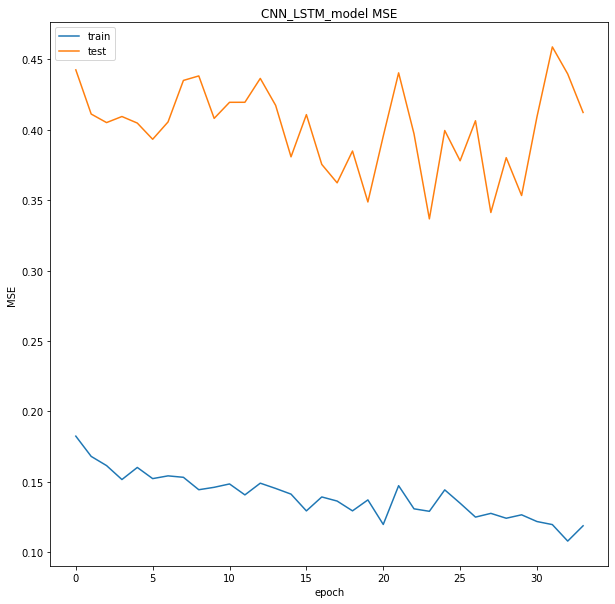

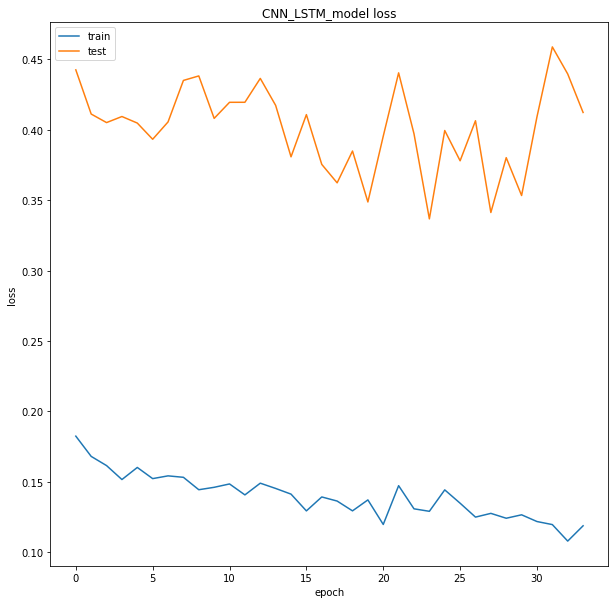

In [56]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("CNN_LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("CNN_LSTM_loss1.png")


We will now run this validation data through our CNN-LSTM model and visualize its performance 

4/4 - 0s - loss: 0.0054 - mse: 0.0054 - 22ms/epoch - 6ms/step

MSE: 0.005449738819152117
4/4 [==============================] - 0s 2ms/step


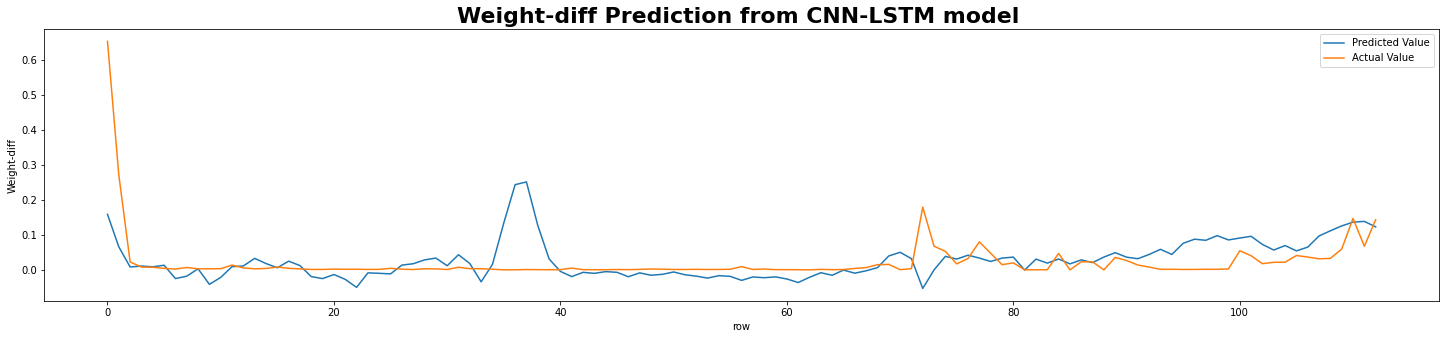

In [57]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('Weight-diff_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Weight-diff Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Weight-diff')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("Weight-diff_Predictions5.png")